In [59]:
import jupedsim as jps
import pedpy
import read_geometry as rr
from shapely import Polygon, to_wkt, Point, LinearRing
import pathlib
from numpy.random import normal
import random
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
import random
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy

In [3]:
wkt = rr.parse_geo_file("./Jaleanwala_Bagh.xml")

In [4]:
# simulation might start with less than that, cause we will finlter out some bad positions
walkable_area0 = wkt[0]
holes = walkable_area0.interiors[1:]
holes.append(LinearRing([(84, 90), (84, 87), (90, 87), (90, 90), (84, 90)]))
walkable_area = Polygon(shell=walkable_area0.exterior, holes=holes)
exit_areas = [
    Polygon([(216, 124), (217.5, 124), (217.5, 123), (216, 123)]),
    Polygon([(67, 116), (68.5, 116), (68.5, 115), (67, 115)]),
    Polygon([(147, -7), (148.5, -7), (148.5, -6), (147, -6)]),
    Polygon([(92, 0), (93.5, 0), (93.5, 1), (92, 1)]),
    #Polygon(
    #    [(213.326, 41.2927), (213.21, 39.7972), (212.21, 39.7972), (212.21, 41.2927)]
    #),
    Polygon( [(213.326, 46.2927), (213.21, 49.7972), (212.21, 49.7972), (212.21, 46.2927)]),
]
spawning_area = Polygon([(60, 99), (172, 99), (172, 11), (60, 11)])

In [5]:
def distribute_agents(num_agents, seed):
    threshold_distance = 0.5
    pos_in_spawning_area = jps.distributions.distribute_by_number(
        polygon=spawning_area,
        number_of_agents=num_agents,
        distance_to_agents=0.3,
        distance_to_polygon=0.5,
        seed=seed,
    )
    pos_in_spawning_area = [
        point
        for point in pos_in_spawning_area
        if not any(
            Polygon(hole).contains(Point(point))
            or Polygon(hole).distance(Point(point)) < threshold_distance
            for hole in holes
        )
    ]
    return pos_in_spawning_area

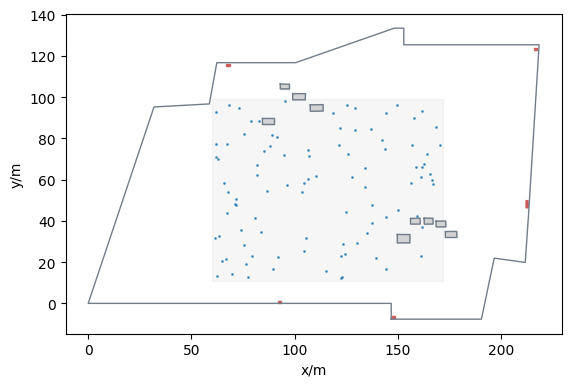

In [6]:
def plot_simulation_configuration(
    walkable_area, spawning_area, starting_positions, exit_areas
):
    axes = pedpy.plot_walkable_area(walkable_area=pedpy.WalkableArea(walkable_area))
    axes.fill(*spawning_area.exterior.xy, color="lightgrey", alpha=0.2)
    for exit_area in exit_areas:
        axes.fill(*exit_area.exterior.xy, color="indianred")
    axes.scatter(*zip(*starting_positions), s=1, alpha=0.7)
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")

pos_in_spawning_area = distribute_agents(num_agents=100,seed=1)
plot_simulation_configuration(
    walkable_area, spawning_area, pos_in_spawning_area, exit_areas
)

In [48]:
def calculate_probability(point, time_elapsed, lambda_decay, time_scale):
    min_x, _, max_x, _ = walkable_area.bounds
    distance_to_left = point.x - min_x
    max_distance = max_x - min_x
    distance_factor = distance_to_left / max_distance
    normalized_time = time_elapsed / time_scale
    distance_factor = 1 - np.exp(-2*(distance_to_left / max_distance))
    probability = distance_factor * np.exp(-lambda_decay * normalized_time)
    return probability

In [8]:
def get_nearest_exit_id(
    position: Point, exit_areas: List[Polygon], exit_ids: List[int]
) -> int:
    """Returns the nearest exit to the position."""
    min_distance = float("inf")
    selected_exit_id = None
    for exit_id, exit_area in zip(exit_ids, exit_areas):
        distance = Point(position).distance(exit_area)
        if distance < min_distance:
            min_distance = distance
            selected_exit_id = exit_id

    return selected_exit_id

In [9]:
def run_simulation(
    time_scale,
    lambda_decay,
    update_time,
    threshold,
    v0_max,
    seed,
    walkable_area,
    exit_areas,
    num_agents,
):
    trajectory_file = f"traj/trajectory_N{num_agents}_S{seed}_L{lambda_decay}.sqlite"
    pos_in_spawning_area = distribute_agents(num_agents=num_agents, seed=seed)
    print(f"lambda decay {lambda_decay}. num_agents: {len(pos_in_spawning_area)}")
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(),
        geometry=walkable_area,
        dt=0.05,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file)
        ),
    )

    exit_ids = []
    for exit_area in exit_areas:
        exit_id = simulation.add_exit_stage(exit_area)
        exit_ids.append(exit_id)

    journey_id = simulation.add_journey(jps.JourneyDescription(exit_ids))
    num_agents = len(pos_in_spawning_area)
    v_distribution = normal(v0_max, 0.05, num_agents)
    for pos, v0 in zip(pos_in_spawning_area, v_distribution):
        simulation.add_agent(
            jps.CollisionFreeSpeedModelAgentParameters(
                journey_id=journey_id,
                stage_id=get_nearest_exit_id(pos, exit_areas, exit_ids),
                position=pos,
                v0=v0,
                radius=0.15,
            )
        )

    time_elapsed = 0
    simulation.elapsed_time()
    dont_stop = True
    while simulation.agent_count() > 0 and dont_stop:
        simulation.iterate()
        if simulation.elapsed_time() % update_time < 0.01:
            # print(f"Iteration: {simulation.iteration_count()}")
            dont_stop = False
            for agent in simulation.agents():
                prob = calculate_probability(
                    Point(agent.position), time_elapsed, lambda_decay, time_scale
                )
                agent.model.v0 *= prob
                if agent.model.v0 > threshold and not dont_stop:
                    dont_stop = True
                    # print(simulation.iteration_count(), agent.model.v0)

    print(
        f"evacuation time: {simulation.iteration_count() * simulation.delta_time():.2f} s. Still in: {simulation.agent_count()}"
    )

    return (
        simulation.iteration_count() * simulation.delta_time(),
        simulation.agent_count(),
    )

In [11]:
num_agents = 50
time_scale = 600  # in seconds = 10 min of shooting
update_time = 20  # in seconds
speed_threshold = 0.1  #  below this is dead / m/s 
v0_max = 3  # m/s
num_reps = 1
evac_times = {}
lambda_decays = [1]
dead = {}

for lambda_decay in lambda_decays:
    res = Parallel(n_jobs=1)(
        delayed(run_simulation)(
            time_scale=time_scale,
            lambda_decay=lambda_decay,
            update_time=update_time,
            threshold=speed_threshold,
            v0_max=v0_max,
            seed=random.randint(1, 10000),
            walkable_area=walkable_area,
            exit_areas=exit_areas,
            num_agents=num_agents
        )
        for _ in range(num_reps)
    )
    res = np.array(res)
    evac_times[lambda_decay] = res[:,0]
    dead[lambda_decay] = res[:,1]


lambda decay 1. num_agents: 47
evacuation time: 38.35 s. Still in: 0


In [ ]:
lambda_decays = [1, 5, 10]
mean_evac_times = {scenario: np.mean(times) for scenario, times in evac_times.items()}
std_dev_evac_times = {scenario: np.std(times) for scenario, times in evac_times.items()}

mean_dead = {scenario: np.mean(dead) for scenario, dead in dead.items()}
std_dead = {scenario: np.std(dead) for scenario, dead in dead.items()}

means = [mean_evac_times[scenario] for scenario in lambda_decays]
std_devs = [std_dev_evac_times[scenario] for scenario in lambda_decays]

means1 = [mean_dead[scenario] for scenario in lambda_decays]
std_devs1 = [std_dead[scenario] for scenario in lambda_decays]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.errorbar(lambda_decays, means, yerr=std_devs, fmt="o-", ecolor="blue")

ax1.set_xlabel("lambda decay")
ax1.set_ylabel("max simulation time")

ax2.errorbar(lambda_decays, means1, yerr=std_devs1, fmt="o-", ecolor="red")
ax2.set_xlabel("lambda decay")
ax2.set_ylabel("# dead people")
plt.tight_layout()
plt.show()

In [ ]:
# animate(trajectory_data, pedpy.WalkableArea(walkable_area))

In [ ]:
# df = trajectory_data.data
# # Step 1: Filter to the last frame
# last_frame = df["frame"].max()
# last_frame_data = df[df["frame"] == last_frame]
# # Step 2: Check if each agent in the last frame is within the walkable area
# # Assuming walkable_area is a Shapely Polygon

# in_walkable_area = last_frame_data.apply(
#     lambda row: walkable_area.contains(Point(row["x"], row["y"])), axis=1
# )

# # Step 3: Count the number of agents in the walkable area
# agents_in_walkable_area = in_walkable_area.sum()
# print(f"Agents still in the area (probably dead by now): {agents_in_walkable_area}")

In [ ]:
polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])


# Function to generate a random point within a polygon
def random_point_in_polygon(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    while True:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if poly.contains(point):
            return point


# Distribute agents
num_agents = 10
lambda_decay = 3
agents = [random_point_in_polygon(polygon) for _ in range(num_agents)]

# Calculate initial probabilities
time_elapsed = 0
time_scale = 10 * 60  # in seconds
probabilities0 = [
    calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
    for agent in agents
]

# Update probabilities over time
# For demonstration, let's say time_elapsed increases
p = [probabilities0[0]]

while time_elapsed < time_scale:
    time_elapsed += 1  # Increment time
    probabilities1 = [
        calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
        for agent in agents
    ]
    p.append(probabilities1[0])

# plt.plot(p,'.')

In [61]:
min_x, min_y, max_x, max_y = walkable_area.bounds

# Grid resolution
x_resolution = 100
y_resolution = 100

# Time points
time_points = [1, 5, 10]  # Example time points
# lambda_decay = 1  # Example lambda_decay value
# time_scale = 5  # Example time_scale

# Generate grid points
x = np.linspace(min_x, max_x, x_resolution)
y = np.linspace(min_y, max_y, y_resolution)
xx, yy = np.meshgrid(x, y)
grid_points = np.vstack((xx.flatten(), yy.flatten())).T

lambda_decay = 0.5
# Plotting heat maps
for time in range(0, time_scale, 10):
    probabilities = [
        calculate_probability(Point(px, py), time, lambda_decay, time_scale)
        if walkable_area.contains(Point(px,py)) else np.nan
        for px, py in grid_points 
    ]
    prob_matrix = np.reshape(probabilities, (x_resolution, y_resolution))

    plt.figure()
    ax = plt.gca()
    cmap = copy.copy(plt.cm.jet_r)  # Or use any other colormap
    cmap.set_bad(color='white')
    im = ax.imshow(
        prob_matrix,
        extent=(min_x, max_x, min_y, max_y),
        origin="lower",
        vmin=0,
        vmax=1,
        cmap=cmap,
    )
   
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    # colorbar(label='Probability')
    plt.colorbar(im, cax=cax, label='Probability')
    ax.set_title(f"Time {time:03d} [s]")
    #plt.xlabel("X Coordinate")
    #plt.ylabel("Y Coordinate")
    plt.savefig(f"png/heatmap_time_{time:03d}.png")  # Save the figure

/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gn/T/ipykernel_55709/2574586622.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


In [23]:
print(f"{1:03d}")

001


In [25]:
time_scale

600